In [9]:
from collections import Counter
import pandas as pd
from math import log2
import matplotlib.pyplot as plt
from scipy.stats import fisher_exact

In [10]:
N = 3

data = pd.read_csv("../../datasets/students_simple.csv")

In [11]:
def prepare_numbers(N):
    N1 = N % 5
    N2 = (N ** 2) % 5 + 5
    return N1, N2

N1, N2 = prepare_numbers(N)
N1, N2

(3, 9)

In [12]:
x = data.iloc[:, N1]  #iq
x

0      95
1     115
2     111
3      97
4     105
5      98
6     109
7     120
8     122
9      92
10    110
11    102
12    108
13    100
14    104
15    104
16    128
17    106
18    105
19    117
Name: iq, dtype: int64

In [13]:
n = x.shape[0]
n

20

In [14]:
y = data.iloc[:, N2]  #test_time
y

0      8.5
1      6.2
2      6.8
3     12.0
4      7.5
5     10.0
6      7.2
7      4.2
8      3.5
9      9.5
10     7.8
11     8.0
12     6.0
13     4.8
14     8.6
15    10.0
16     4.5
17    12.5
18    10.5
19     6.5
Name: test_time, dtype: float64

In [16]:
import numpy as np

def calculate_fechner(x, y):
    x_sign = np.sign(x - x.mean())
    y_sign = np.sign(y - y.mean())

    N_minus = np.count_nonzero(x_sign - y_sign)
    N_plus = x.shape[0] - N_minus

    fechner_corr = (N_plus - N_minus) / (N_plus + N_minus)
    return fechner_corr

calculate_fechner(x, y)

np.float64(-0.7)

In [17]:
def calculate_pirson(x, y):
    x_norm = x - x.mean()
    y_norm = y - y.mean()

    pirson_corr = np.sum(x_norm * y_norm) / (x.shape[0] * np.std(x_norm) * np.std(y_norm))
    return pirson_corr

calculate_pirson(x, y)

np.float64(-0.6818137442428807)

In [18]:
pirson_corr = calculate_pirson(x, y)

np.sqrt(1 - pirson_corr ** 2) / np.sqrt(n-2)

np.float64(0.17242228815735186)

In [20]:
from scipy.stats import rankdata

x_rank = rankdata(x)
y_rank = rankdata(y)

def calculate_spierman(x_rank, y_rank):
    counter1 = Counter(x_rank)
    counter2 = Counter(y_rank)
    term = ((n ** 3 - n) / 6)
    T_x = sum(k ** 3 - k for _, k in counter1.items()) / 12
    T_y = sum(k ** 3 - k for _, k in counter2.items()) / 12
    numerator = term - np.sum(np.pow(x_rank - y_rank, 2)) - T_x - T_y
    denominator = np.sqrt((term - T_x) * (term - T_y))
    spierman_corr = numerator / denominator
    return spierman_corr

calculate_spierman(x_rank, y_rank)

np.float64(-0.68196352532076)

In [21]:
def calculate_kendall(x_rank, y_rank):
    concordant = 0
    discordant = 0
    x_ties = 0
    y_ties = 0

    for i in range(n):
        for j in range(i + 1, n):
            x_diff = x_rank[i] - x_rank[j]
            y_diff = y_rank[i] - y_rank[j]

            product = x_diff * y_diff

            if product > 0:
                concordant += 1
            elif product < 0:
                discordant += 1
            else:
                if x_diff == 0:
                    x_ties += 1
                if y_diff == 0:
                    y_ties += 1

    total_pairs = n * (n - 1) // 2
    numerator = concordant - discordant
    denominator = np.sqrt((total_pairs - x_ties) * (total_pairs - y_ties))

    kendall_corr = numerator / denominator
    return kendall_corr

calculate_kendall(x, y)



np.float64(-0.503980552812724)

(array([4., 7., 4., 3., 2.]),
 array([ 92. ,  99.2, 106.4, 113.6, 120.8, 128. ]),
 <BarContainer object of 5 artists>)

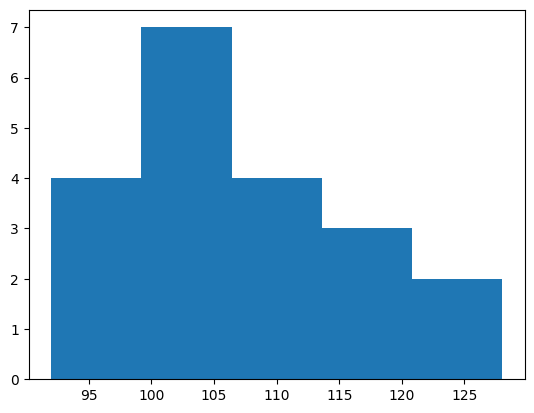

In [22]:
plt.hist(x, bins=1+int(log2(n)))

(array([1., 1., 1., 1., 1., 1., 2., 3., 1., 1., 2., 0., 1., 1., 0., 1., 1.,
        0., 0., 1.]),
 array([ 92. ,  93.8,  95.6,  97.4,  99.2, 101. , 102.8, 104.6, 106.4,
        108.2, 110. , 111.8, 113.6, 115.4, 117.2, 119. , 120.8, 122.6,
        124.4, 126.2, 128. ]),
 <BarContainer object of 20 artists>)

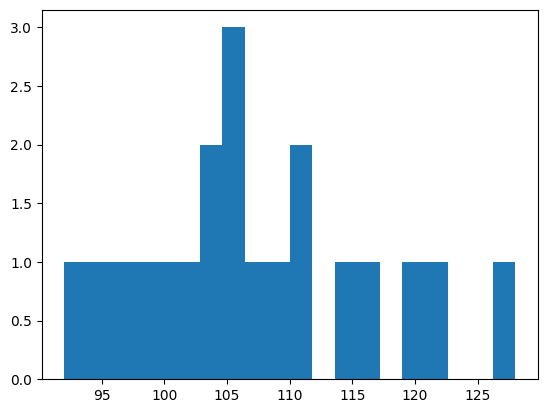

In [23]:
plt.hist(x, bins=n)

(array([4., 4., 6., 4., 2.]),
 array([ 3.5,  5.3,  7.1,  8.9, 10.7, 12.5]),
 <BarContainer object of 5 artists>)

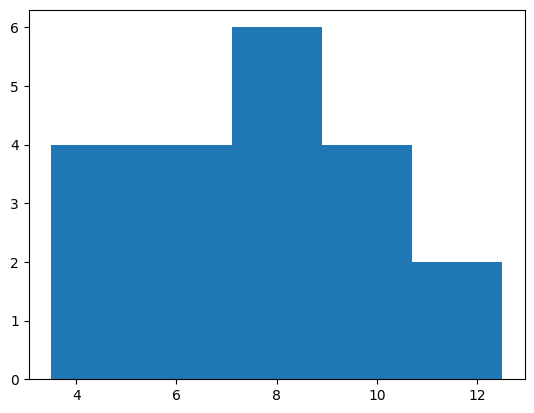

In [24]:
plt.hist(y, bins=1+int(log2(n)))

(array([1., 1., 2., 0., 0., 1., 2., 1., 2., 1., 1., 2., 0., 1., 2., 1., 0.,
        0., 1., 1.]),
 array([ 3.5 ,  3.95,  4.4 ,  4.85,  5.3 ,  5.75,  6.2 ,  6.65,  7.1 ,
         7.55,  8.  ,  8.45,  8.9 ,  9.35,  9.8 , 10.25, 10.7 , 11.15,
        11.6 , 12.05, 12.5 ]),
 <BarContainer object of 20 artists>)

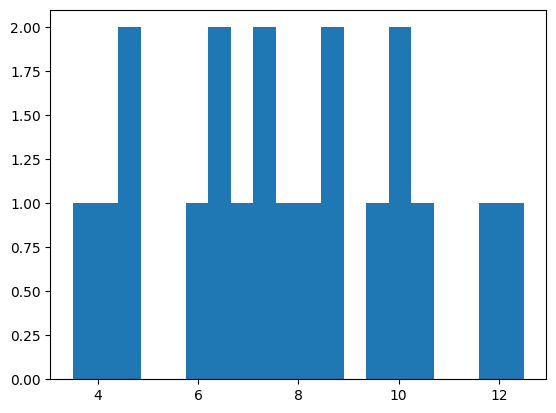

In [25]:
plt.hist(y, bins=n)

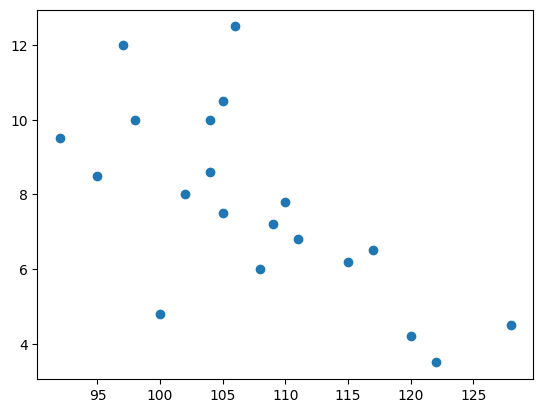

In [26]:
plt.scatter(x, y)

In [27]:
a = pirson_corr * np.std(y) / np.var(x)
b = np.mean(y) - a * np.mean(x)

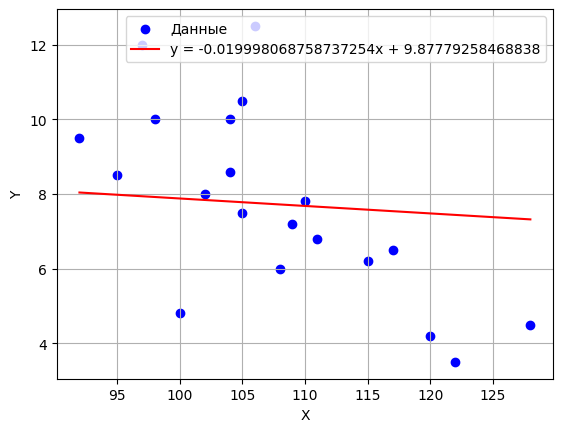

In [28]:
plt.scatter(x, y, color='blue', label='Данные')

x_line = np.linspace(min(x), max(x), 100)
y_line = a * x_line + b

plt.plot(x_line, y_line, color='red', label=f'y = {a}x + {b}')

plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.grid(True)
plt.show()

In [29]:
X_n = np.c_[np.ones(n), x, x**2]
y_n = y
XtX = X_n.T @ X_n
XtX_inv = np.linalg.inv(XtX)
Xty = X_n.T @ y_n
beta = XtX_inv @ Xty
beta

array([-1.18826559e+01,  5.39594178e-01, -3.29986046e-03])

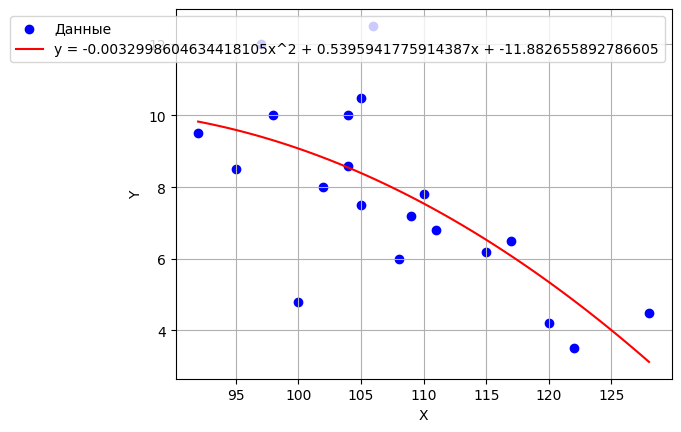

In [31]:
plt.scatter(x, y, color='blue', label='Данные')

x_line = np.linspace(min(x), max(x), 100)
y_line = beta[2] * np.pow(x_line, 2) + beta[1] * x_line + beta[0]

plt.plot(x_line, y_line, color='red', label=f'y = {beta[2]}x^2 + {beta[1]}x + {beta[0]}')

plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.grid(True)
plt.show()

In [32]:
x_inv = 1 / x
X_n = np.c_[np.ones(n), x_inv]
y_n = y
XtX = X_n.T @ X_n
XtX_inv = np.linalg.inv(XtX)
Xty = X_n.T @ y_n
beta = XtX_inv @ Xty
beta

array([ -11.88594408, 2091.874046  ])

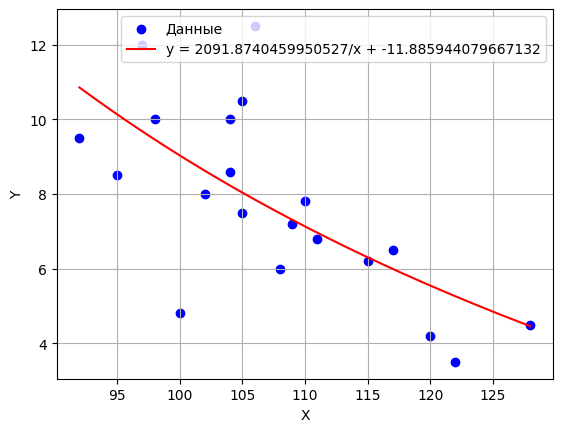

In [33]:
plt.scatter(x, y, color='blue', label='Данные')

x_line = np.linspace(min(x), max(x), 100)
y_line = (beta[1] / x_line) + beta[0]

plt.plot(x_line, y_line, color='red', label=f'y = {beta[1]}/x + {beta[0]}')

plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.grid(True)
plt.show()

In [34]:
fisher_exact([(beta[1] / x) + beta[0], y])

SignificanceResult(statistic=np.float64(4.294976267716137e-14), pvalue=np.float64(0.9995))

In [35]:
x_inv = x
X_n = np.c_[np.ones(n), x]
y_n = np.log(y)
XtX = X_n.T @ X_n
XtX_inv = np.linalg.inv(XtX)
Xty = X_n.T @ y_n
beta = XtX_inv @ Xty
beta

array([ 4.87367985, -0.02685064])

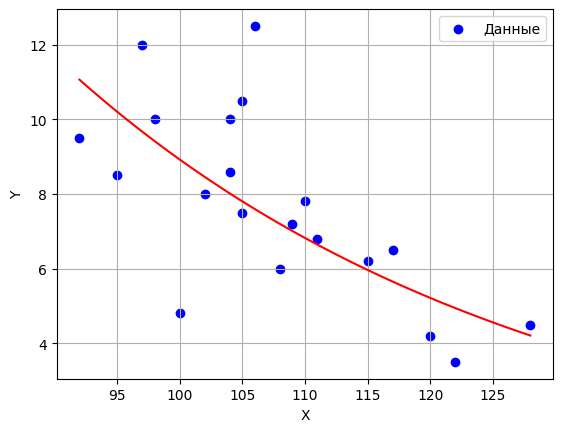

In [36]:
plt.scatter(x, y, color='blue', label='Данные')

x_line = np.linspace(min(x), max(x), 100)
y_line = np.exp((beta[1] * x_line) + beta[0])

plt.plot(x_line, y_line, color='red')

plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.grid(True)
plt.show()

In [37]:
fisher_exact([a * x + b, y])

SignificanceResult(statistic=np.float64(8.330852968812752e-15), pvalue=np.float64(0.9818))